<a href="https://colab.research.google.com/github/Hussain-amaan/sentimental-analysis/blob/main/sentimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

libraries



In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, LSTM, GRU
from tensorflow .keras.layers import Dense,Dropout ,LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import re
import zipfile
import os

In [2]:
zip_file_path = '/content/drive/MyDrive/archive (2).zip'
extract_dir = '/content/data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"'{zip_file_path}' extracted to '{extract_dir}'")

'/content/drive/MyDrive/archive (2).zip' extracted to '/content/data'


In [3]:
with bz2.BZ2File("/content/data/train.ft.txt.bz2") as f:
    train_data = [f.readline().decode("utf-8").strip() for _ in range (15000)]

In [4]:
len(train_data)

15000

In [5]:
with bz2.BZ2File("/content/data/test.ft.txt.bz2") as f:
    test_data = [f.readline().decode("utf-8").strip() for _ in range (5000)]

In [6]:
len(test_data)

5000

In [7]:
train_data[0:6]

['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 '__label__2 Amazing!: This sound

In [8]:
test_data[0:6]

['__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too ma

In [9]:
train_labels=[int(re.findall(r'__label__(\d)',line)[0]) for line in train_data]
train_text=[re.sub(r'__label__\d','',line) for line in train_data]

test_labels=[int(re.findall(r'__label__(\d)',line)[0]) for line in test_data]
test_text=[re.sub(r'__label__\d','',line) for line in test_data]

train_labels=[0 if labels==1 else 1 for labels in train_labels]
test_labels=[0 if labels==1 else 1 for labels in test_labels]

In [10]:
train_labels[0:20]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]

In [11]:
train_text[0:20]

[' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 " The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 ' Amazing!: This soundtrack is my favorite music of 

text cleaning :


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
def clean_txt(text):
  ps=PorterStemmer()
  stop_words=set(stopwords.words('english'))


  text=text.lower()
  text=re.sub(r"a-z\s",'',text)
  words=text.split()
  words= [ ps.stem(word) for word in words if word not in stop_words]

  return " ".join(words)

In [14]:
train_text_sub=[clean_txt(text) for text in train_text[:]]

In [15]:
test_text_sub=[clean_txt(text) for text in test_text]

In [16]:
train_text[0]

' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

Tokenization

In [17]:
max_word=1000
max_seq_len=100

tokenizer=Tokenizer(num_words=max_word)
tokenizer.fit_on_texts(train_text_sub)


In [18]:
X_train=tokenizer.texts_to_sequences(train_text_sub)

In [19]:
X_train[0]

[19,
 557,
 87,
 205,
 937,
 296,
 18,
 9,
 19,
 70,
 396,
 85,
 36,
 74,
 85,
 85,
 45,
 74,
 25,
 36,
 46,
 175,
 66,
 879,
 799,
 9,
 535,
 154,
 300,
 104]

In [20]:
X_test=tokenizer.texts_to_sequences(test_text_sub)

In [21]:
X_test[0]

[7,
 20,
 12,
 2,
 7,
 247,
 104,
 20,
 42,
 62,
 12,
 5,
 6,
 15,
 84,
 28,
 53,
 4,
 20,
 80,
 856,
 884,
 647,
 2,
 20,
 1,
 43,
 64,
 129,
 744,
 92,
 74,
 147,
 523,
 463,
 641,
 322,
 73,
 39,
 2,
 44,
 311]

In [22]:
X_train=pad_sequences(X_train,maxlen=max_seq_len)
X_test=pad_sequences(X_test,maxlen=max_seq_len)

In [23]:
X_train[0:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  19, 557,  87, 205, 937, 296,  18,   9,
         19,  70, 396,  85,  36,  74,  85,  85,  45,  74,  25,  36,  46,
        175,  66, 879, 799,   9, 535, 154, 300, 104],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  25, 896,  45,   3,  83,  59,  39,  25, 454, 14

In [24]:
X_test[0:5]


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   7,  20,  12,   2,   7, 247, 104,
         20,  42,  62,  12,   5,   6,  15,  84,  28,  53,   4,  20,  80,
        856, 884, 647,   2,  20,   1,  43,  64, 129, 744,  92,  74, 147,
        523, 463, 641, 322,  73,  39,   2,  44, 311],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  25,
         85,  36, 896,  85,  17,  74, 865, 194,  74, 208,  85,  36, 263,
        851, 488,   7,  18,  96, 896,   2, 230, 566, 588, 148, 730, 435,
        489, 271, 205, 279,   4, 465,  50, 265,  37, 146,  85,  98, 82

In [25]:
X_train=np.array(X_train)  # converting  into array from list of list
X_test=np.array(X_test)
y_train=np.array(train_labels)
y_test=np.array(test_labels)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15000, 100)
(5000, 100)
(15000,)
(5000,)


Training RNN

In [27]:
model= Sequential([
    Embedding(input_dim=max_word,output_dim=300,input_length=max_seq_len),
    SimpleRNN(128,return_sequences=True,dropout=0.3),    # rnn with dropout
    LayerNormalization(),# normalization for stability

    SimpleRNN(128, dropout=0.3),  # 2nd rnn
    LayerNormalization(),
    Dropout(0.3),


    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')  # binary output


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
model.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=5e-5),
               metrics=['accuracy'])

early_stopping= EarlyStopping(monitor='val_loss',
                             patience=5,restore_best_weights=True)

history=model.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=512,
                   validation_data=(X_test,y_test),
                   callbacks=[early_stopping],
                   verbose=1
                   )

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 310ms/step - accuracy: 0.4991 - loss: 0.9122 - val_accuracy: 0.5090 - val_loss: 0.7192
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5127 - loss: 0.7692 - val_accuracy: 0.5126 - val_loss: 0.6962
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5028 - loss: 0.7461 - val_accuracy: 0.5172 - val_loss: 0.6969
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5048 - loss: 0.7360 - val_accuracy: 0.5154 - val_loss: 0.6968
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5029 - loss: 0.7304 - val_accuracy: 0.5144 - val_loss: 0.6955
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5052 - loss: 0.7225 - val_accuracy: 0.5136 - val_loss: 0.6957
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5088 - loss: 0.7150 - val_accuracy: 0.5140 - val_loss: 0.6940
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5060 - loss: 0.7108 - val_accuracy: 

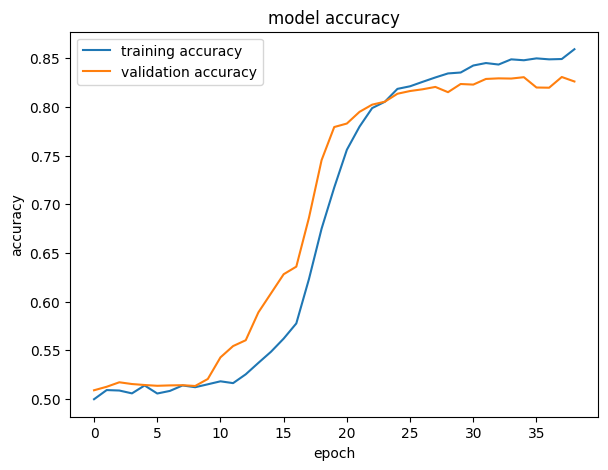

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


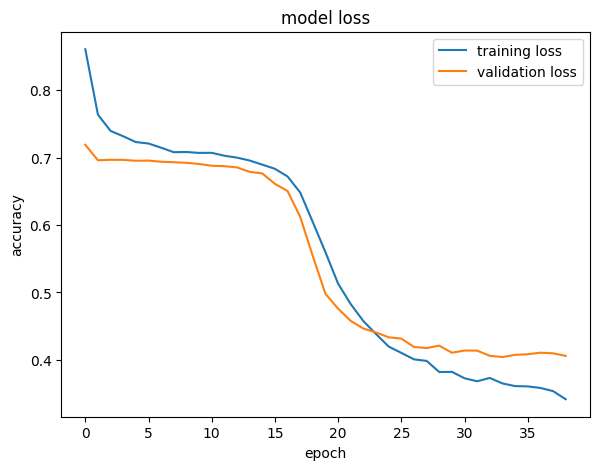

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [42]:
y_pred=model.predict(X_test)
y_pred= (y_pred>0.5)

cm=confusion_matrix(y_test,y_pred)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [43]:
cm

array([[1956,  479],
       [ 375, 2190]])

In [44]:
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2435
           1       0.82      0.85      0.84      2565

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



Trainig BiLSTM

In [48]:
model_lstm= Sequential([
    Embedding(input_dim=max_word,output_dim=300,input_length=max_seq_len),
    Bidirectional(LSTM(128,return_sequences=True, recurrent_dropout=0.3)),    # rnn with dropout
    LayerNormalization(),# normalization for stability
    Dropout(0.3),

    Bidirectional(LSTM(128, recurrent_dropout=0.3)),  # 2nd rnn
    LayerNormalization(),
    Dropout(0.3),


    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')  # binary output


])

model_lstm.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=5e-5),
               metrics=['accuracy'])

early_stopping= EarlyStopping(monitor='val_loss',
                             patience=5,restore_best_weights=True)

history=model_lstm.fit(X_train,
                   y_train,
                   epochs=100,
                   batch_size=512,
                   validation_data=(X_test,y_test),
                   callbacks=[early_stopping],
                   verbose=1
                   )

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5072 - loss: 0.8063 - val_accuracy: 0.5804 - val_loss: 0.6785
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5498 - loss: 0.7026 - val_accuracy: 0.6366 - val_loss: 0.6546
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5930 - loss: 0.6690 - val_accuracy: 0.6932 - val_loss: 0.6081
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6489 - loss: 0.6248 - val_accuracy: 0.7344 - val_loss: 0.5446
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7153 - loss: 0.5542 - val_accuracy: 0.7538 - val_loss: 0.4978
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7637 - loss: 0.4993 - val_accuracy: 0.7780 - val_loss: 0.4651
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7907 - loss: 0.4606 - val_accuracy: 0.7938 - val_loss: 0.4454
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8078 - loss: 0.4309 - val_accuracy: 0.7946 - val_loss: 0.4

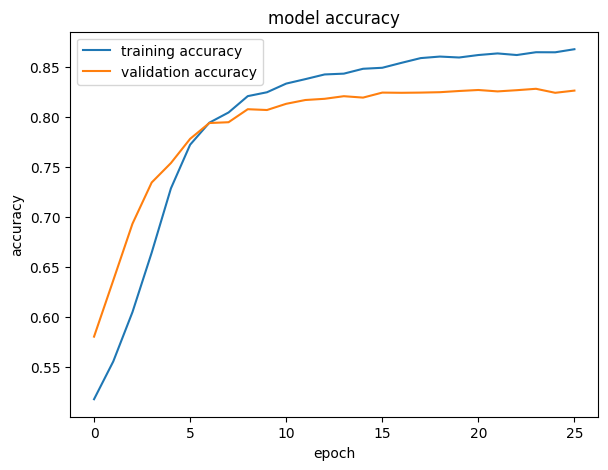

In [49]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


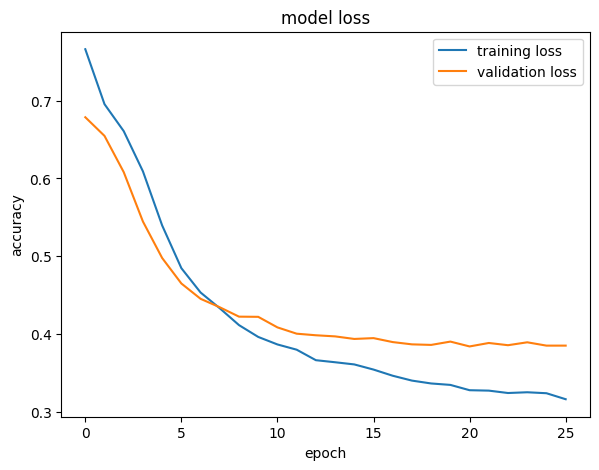

In [50]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [53]:
y_pred=model_lstm.predict(X_test)
y_pred= (y_pred>0.5)

cm=confusion_matrix(y_test,y_pred)
print(cm)

157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 239ms/step
[[1958  477]
 [ 389 2176]]


In [54]:
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2435
           1       0.82      0.85      0.83      2565

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



Training GRU:

In [61]:
model_GRU= Sequential([
    Embedding(input_dim=max_word,output_dim=300,input_length=max_seq_len),
    GRU(128,return_sequences=True, dropout=0.3 , recurrent_dropout=0.2),    # rnn with dropout
    LayerNormalization(),# normalization for stability
    Dropout(0.3),

    GRU(128, dropout=0.3, recurrent_dropout=0.2),  # 2nd rnn
    LayerNormalization(),
    Dropout(0.3),


    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')  # binary output


])

model_GRU.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=5e-5),
               metrics=['accuracy'])

early_stopping= EarlyStopping(monitor='val_loss',
                             patience=5,restore_best_weights=True)

history=model_GRU.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=512,
                   validation_data=(X_test,y_test),
                   callbacks=[early_stopping],
                   verbose=1
                   )

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 717ms/step - accuracy: 0.4961 - loss: 0.9055 - val_accuracy: 0.5476 - val_loss: 0.7395
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 632ms/step - accuracy: 0.5311 - loss: 0.7844 - val_accuracy: 0.5706 - val_loss: 0.7105
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.5460 - loss: 0.7569 - val_accuracy: 0.6012 - val_loss: 0.6702
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.5755 - loss: 0.7140 - val_accuracy: 0.6154 - val_loss: 0.6547
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.5826 - loss: 0.6980 - val_accuracy: 0.6358 - val_loss: 0.6332
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 623ms/step - accuracy: 0.5964 - loss: 0.6860 - val_accuracy: 0.6466 - val_loss: 0.6227
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 650ms/step - accuracy: 0.6152 - loss: 0.6658 - val_accuracy: 0.6566 - val_loss: 0.6092
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 703ms/step - accuracy: 0.6272 - loss: 0.6526 - val_accu

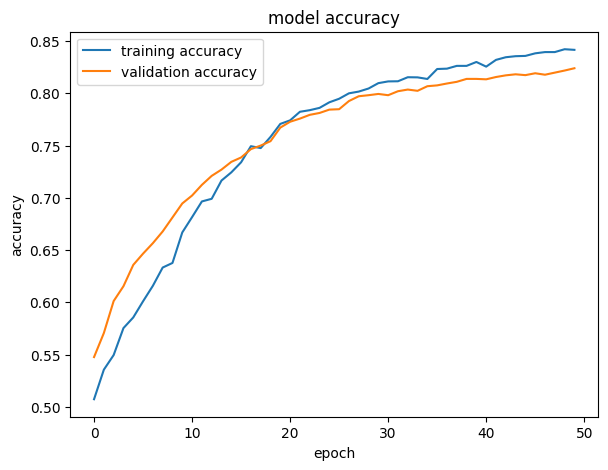

In [62]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


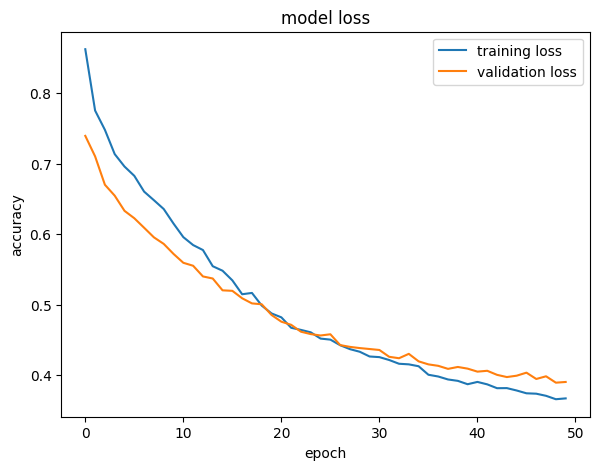

In [63]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [64]:
y_pred=model_GRU.predict(X_test)
y_pred= (y_pred>0.5)

cm=confusion_matrix(y_test,y_pred)
print(cm)

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step
[[1925  510]
 [ 381 2184]]


In [65]:
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2435
           1       0.81      0.85      0.83      2565

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



Now you can test the predictive system with new text inputs.

In [76]:
def predict_sentiment(text):
  """Predicts the sentiment of a given text using the SimpleRNN model."""

  # Clean and preprocess the text
  cleaned_text = clean_txt(text)

  # Tokenize and pad the text
  sequence = tokenizer.texts_to_sequences([cleaned_text])
  padded_sequence = pad_sequences(sequence, maxlen=max_seq_len)

  # Make the prediction
  prediction = model_lstm.predict(padded_sequence)

  # Return the sentiment label
  if prediction[0][0] > 0.5:
    return "Positive"
  else:
    return "Negative"

In [77]:
text1 = "This is a fantastic product! I love it."
sentiment1 = predict_sentiment(text1)
print(f"Text: '{text1}'\nSentiment: {sentiment1}")

text2 = "This is a terrible product. I regret buying it."
sentiment2 = predict_sentiment(text2)
print(f"\nText: '{text2}'\nSentiment: {sentiment2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Text: 'This is a fantastic product! I love it.'
Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step

Text: 'This is a terrible product. I regret buying it.'
Sentiment: Negative


In [82]:
import pickle

# Save SimpleRNN model
with open('simple_rnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save BiLSTM model
with open('bilstm_model.pkl', 'wb') as f:
    pickle.dump(model_lstm, f)

# Save GRU model
with open('gru_model.pkl', 'wb') as f:
    pickle.dump(model_GRU, f)

print("Models saved successfully!")

Models saved successfully!
